# Определение возраста по изображению

**Задача**

Супермаркет планирует использовать систему компьютерного зрения для обработки изображения клиентов.
Клиенты будут фотографироваться на прикассовой зоне для определения  их возраста.

Использоваться эта информация будет для:

 - анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы.
 - контроля продажи алкоголя 
 
Постройте и обучите свёрточную нейронную которая по изображению определит приблизительный возраст человека. Добейтесь значения целевой метрики MAE на тестовой выборке не больше 8.

**Описание данных**:

Набор фотографий людей с указанием возраста. 

Данные взяты с сайта ChaLearn Looking at People. Но изменены командой Яндекс.Практикум

**Структура проекта**:

 - Разбор проекта
 - Исследовательский анализ данных
 - Обучение модели
  - Условие - целевая метрика MAE на тестовой выборке должна быть не больше 8.
 - Анализ обученной модели

# 1. Разбор проекта

Рассмотрим подробнее стоящию перед нами задачу:
 - Нужно определить возраст человека на изображении. Это задача регрессии.
 - Если я буду использовать ResNet50, предобученной на датасете ImageNet. В нём в выходном слое будет 1000 нейронов, мне же нужен всего один, который вернёт число-предсказание.
 - В качестве функции потерь для регресси подойдут Mean Squared Error и Mean Absolute Error.

# 2. Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Загрузим данные и посмотрим на них

In [2]:

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
#7591 изображений

Found 7591 validated image filenames.


In [3]:
print(labels.shape)
labels.head()
#две колонки(c названием изображения и возрастом человека на изображении) 7591 строка

(7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.info()
# пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Text(0.5, 0, 'Возраст')

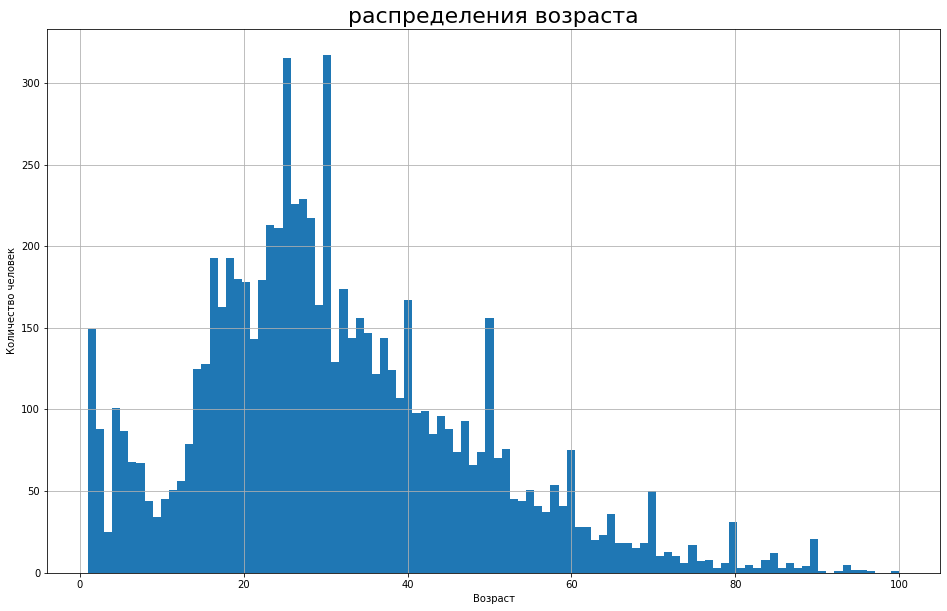

In [7]:
#построим график распределения возраста
labels['real_age'].hist(bins=100, figsize=(16,10))
plt.title("Распределения возраста", fontsize=22)
plt.ylabel("Количество человек")
plt.xlabel("Возраст")

Распределение по возрасту смещено в сторону молодых людей, поскольку набор данных
собирается из общедоступных интернет-хранилищ.
Есть и совсем мылыши, примерно 360 фото с возрастом менее 5 лет. 

In [19]:
features, target = next(train_gen_flow)

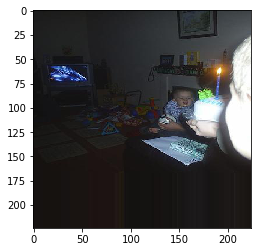

In [14]:
plt.imshow(features[28])
#сможет ли модель определить наличие здесь годовалого ребенка?

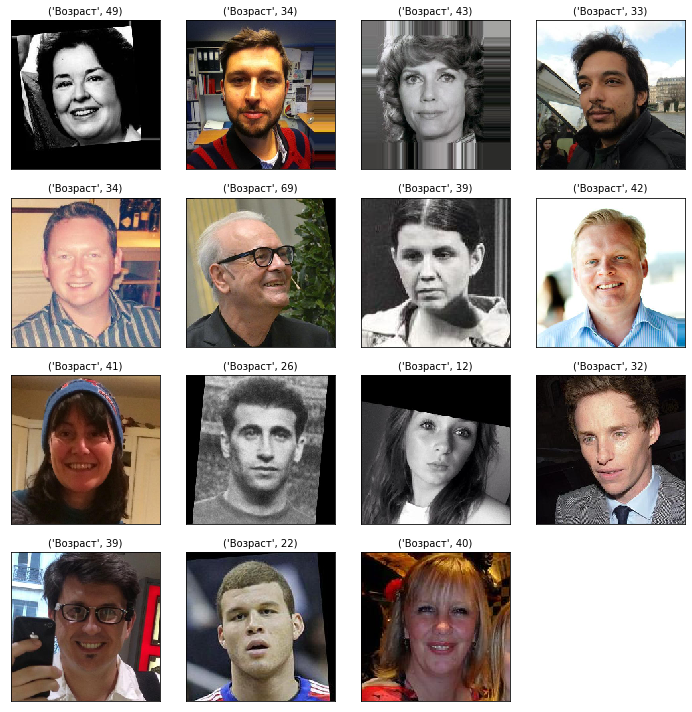

In [34]:
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(('Возраст',target[i]), fontsize=10)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

База данных APPA-REAL содержит 7 591 изображение с соответствующими метками реального возраста.
 
В датасете есть порядка 360 строк где возраст менее 5 лет. Есть и столетние люди. Не факт , что такие данные нужны нашей модели, ведь основные задачи для которых мы её делаем :

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; 
 - Контролировать добросовестность кассиров при продаже алкоголя.

А дети до 5 лет и пожилые люди за 90 редко появляются в магазинах.

Сами изображения представленны как черно белыми так и цветными. Они заранее обрезаны и повернуты.

# 3. Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, который нам предоставлял Яндекс.Практикум. Поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке. Обучать модель можно было до мемента получения целевой метрики MAE на тестовой выборке не больше 8. После менять модель и отправлять в GPU-тренажёр было не возможно. Поэтому особо поизменять модель не удалось. Например можно было использовать горизонтальный флип на тренировочном наборе данных. По сути, это бы позволило бесплатно увеличить выборку в 2 раза корректными изображениями.

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    global labels, datagen
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.20, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    opt = Adam(lr=0.0003)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae']) 

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/5
2020-11-01 07:54:43.818240: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-01 07:54:44.147154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 51s - loss: 193.2297 - mae: 10.1738 - val_loss: 562.9899 - val_mae: 18.5469
Epoch 2/5
190/190 - 42s - loss: 73.0115 - mae: 6.4565 - val_loss: 574.2162 - val_mae: 18.8172
Epoch 3/5
190/190 - 41s - loss: 43.0169 - mae: 5.0103 - val_loss: 504.8116 - val_mae: 17.0584
Epoch 4/5
190/190 - 41s - loss: 28.0287 - mae: 4.0818 - val_loss: 133.7807 - val_mae: 8.6151
Epoch 5/5
190/190 - 41s - loss: 20.2793 - mae: 3.4664 - val_loss: 81.9286 - val_mae: 6.8005
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 81.9286 - mae: 6.8005
Test MAE: 6.8005

# 4. Анализ обученной модели

К сожалению попробовать другие параметры мне почти не удалось. Модель добилась нужного показателя уже со второй попытки, а хотелось еще с ней поработать. Но тренажер такой возможности нам не давал. 

В данный момент выгрузил полный датасет с ChaLearn Looking at People и работаю сним.

Что касаемо самой модели - её обучение заняло 3.5 минуты , наверное это довольно сносно.
Требуемое качество то же достигнуто. 

В среднем модель ошибается на 6.8 лет, но какие объекты вносят наибольший вклад в общую ошибку? 
Возможно если убрать не ролевантные категории , то показатель будет лучше. От 1 до 5 лет и от 90 до 100 например.
Да и данных от 60 - 100 лет не так много , модель может плохо их определять.
Когда подгружал фото из датасета, просматривал фотографии тех чей возраст указан - как 1 год.
Выше есть одно изображение на котором очень сложно определить наличие годовалого ребенка, модель могла сильно ошибиться на этой фотографии, если она попала в тест.